# Lab 4
### Multi-Layer Perceptron
Eric Miao, Sabrina Peng, Fernando Vazquez

CS7324, Fall 2020

In [41]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## 1. Load, Split, Balance

In [42]:
# read data and display all columns

df = pd.read_csv('acs2017_census_tract_data.csv')
df.columns

Index(['TractId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'VotingAgeCitizen',
       'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')

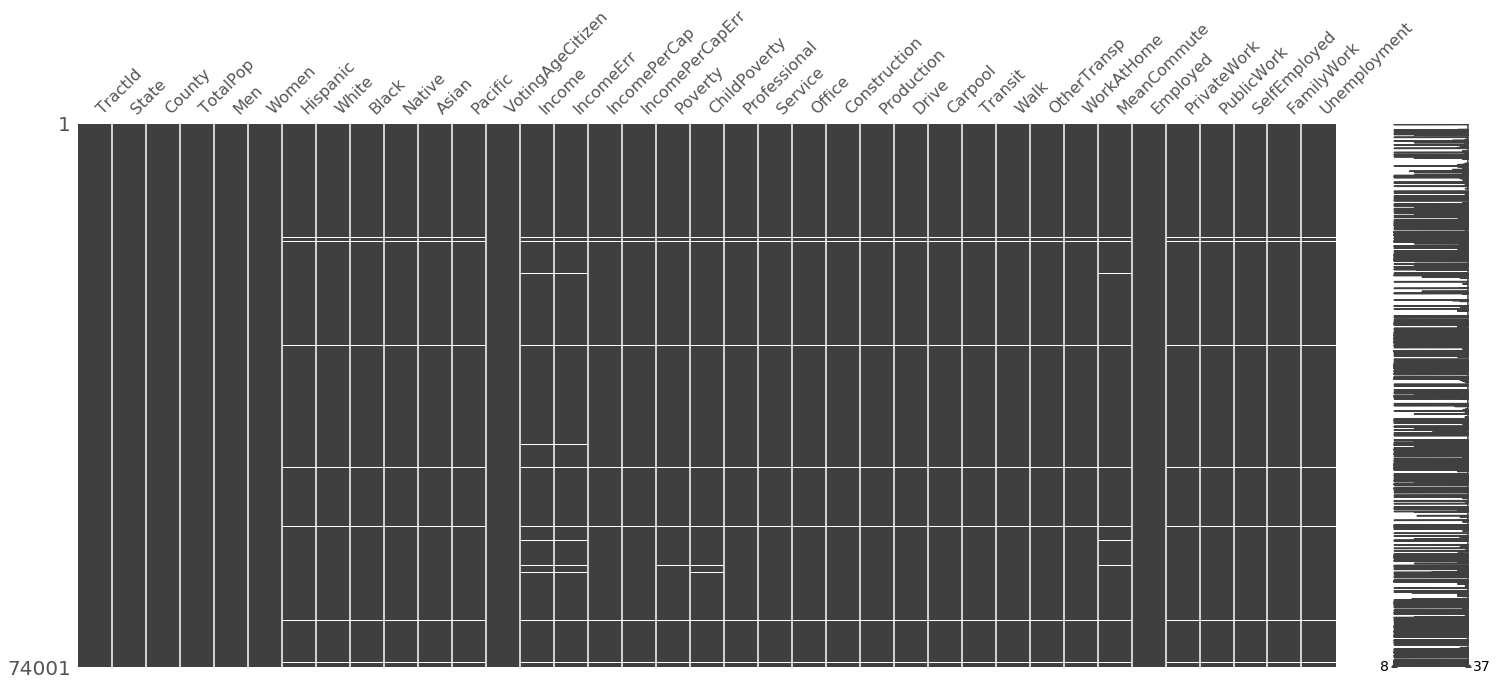

In [43]:
# remove rows with missing data
import missingno as mn

mn.matrix(df)
plt.show()

In [44]:
rows_with_nan = df[df.isnull().any(axis=1)]
num_rows_with_nan = len(rows_with_nan)
print('Number of rows: ', len(df))
print('Number of rows with NaN values: ', num_rows_with_nan)
print('Ratio of rows with NaN to all rows: ', num_rows_with_nan / len(df))

Number of rows:  74001
Number of rows with NaN values:  1283
Ratio of rows with NaN to all rows:  0.017337603545898028


In [45]:
df = df.dropna()
print('New number of rows: ', len(df))

New number of rows:  72718


In [46]:
# drop county
df_new = df.drop(columns=['TractId', 'County'])

# encode string data as integers
df_new['State'] = df_new['State'].astype('category').cat.codes

In [47]:
# split dataset into 80/20 for train/test
from sklearn.model_selection import train_test_split

target_var_name = 'ChildPoverty'

X = df_new.loc[:, df_new.columns != target_var_name]
y = df_new.loc[:, df_new.columns == target_var_name][target_var_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# quantize child poverty variable (% of children under poverty level) into 4 categories

def quantize_child_poverty_rate(cpr):
    if cpr <= 3:
        return 0
    if cpr <= 11:
        return 1
    if cpr <= 22:
        return 2
    if cpr <= 100:
        return 3

y_train = y_train.apply(lambda x: quantize_child_poverty_rate(x))
y_test = y_test.apply(lambda x: quantize_child_poverty_rate(x))

# df_new.loc[:, df_new.columns == target_var_name][target_var_name].quantile([0.25,0.5,0.75])

Class 0 : 8792
Class 1 : 13318
Class 2 : 13266
Class 3 : 22798


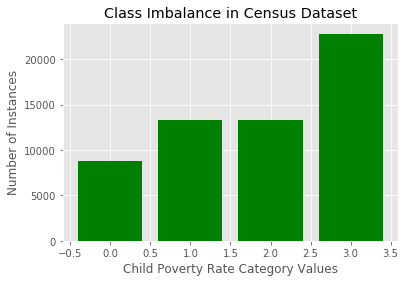

In [49]:
unique_elements, counts_elements = np.unique(list(y_train), return_counts=True)
for target_val, num_instances in zip(unique_elements, counts_elements):
    print('Class', target_val, ':', num_instances)

plt.bar(unique_elements, counts_elements, color='green')
plt.xlabel('Child Poverty Rate Category Values')
plt.ylabel('Number of Instances')
plt.title('Class Imbalance in Census Dataset')
plt.show()

We declared thresholds for our four different categories of child poverty rates by researching current goals and policies focused on reducing child poverty. There is a global goal to get child poverty rates down below 3%, so we chose that as our first threshold. The current average child poverty rate in the U.S. is 21.2%, which is far above the 3% goal. This led us to create our second threshold at half the current U.S. rate, and our third threshold as the current U.S. rate. Establishing these three thresholds gives us a relatively good quantization of our data into four different categories, but this results in unbalanced classes.

To balance the dataset, we conduct random oversampling of the minority classes only on the training data. Balancing the dataset should not be done for both the training and the testing set. Doing balancing on the testing set would be a form of data snooping - misrepresenting the reality of the actual data in the real world. We don't want to massage or disrupt the test data at all. 

Our way of oversampling is known to increase the likelihood of overfitting - a better way would be synthetic minority oversampling technique (SMOTE), but this is a bit difficult to use since we have not encoded our categorical variables yet.

In [50]:
# balance the dataset using random oversampling of the minority classes
# https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-ii-over-sampling-d61b43bc4879

# code adapted from https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]
X_train_3 = X_train[y_train == 3]

X_train_0_under = X_train_0.sample(len(X_train_3) - len(X_train_0), replace=True)
X_train_1_under = X_train_1.sample(len(X_train_3) - len(X_train_1), replace=True)
X_train_2_under = X_train_2.sample(len(X_train_3) - len(X_train_2), replace=True)

y_train_0_under = y_train[X_train_0_under.index]
y_train_1_under = y_train[X_train_1_under.index]
y_train_2_under = y_train[X_train_2_under.index]

X_train = pd.concat([X_train, X_train_0_under, X_train_1_under, X_train_2_under], axis=0)
y_train = pd.concat([y_train, y_train_0_under, y_train_1_under, y_train_2_under], axis=0)

Class 0 : 22798
Class 1 : 22798
Class 2 : 22798
Class 3 : 22798


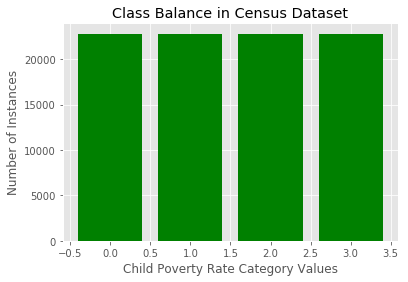

In [51]:
unique_elements, counts_elements = np.unique(list(y_train), return_counts=True)
for target_val, num_instances in zip(unique_elements, counts_elements):
    print('Class', target_val, ':', num_instances)

plt.bar(unique_elements, counts_elements, color='green')
plt.xlabel('Child Poverty Rate Category Values')
plt.ylabel('Number of Instances')
plt.title('Class Balance in Census Dataset')
plt.show()

## 2. Preprocessing

Our base Two Layer MLP model employs minibatching, cross entropy loss function, Glorot initialization, ReLu hidden layers, and the momentum adaptive strategy. We start off with 40 hidden neurons, as an empirically-derived rule of thumb states that the "optimal size of the hidden layer is usually between the size of the input and the size of the output layers," and 40 is about the mean of the sizes of the input and output layers [[1]](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw).

In [52]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [53]:
# imports and helper functions to plot accuracy and cost vs. epochs

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def accuracy_vs_epochs(nn, X_train, y_train, X_test, y_test, title="", color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)
    
def cost_vs_epochs(nn):
    # take the mean of each minibatch epoch
    cost_avgs = [np.mean(x) for x in nn.cost_]

    plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show()

### 2.1 Two Layer Perceptron Model: No Normalization, No Encoding 

In [54]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        return expit(z)
    
    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)  # last layer sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2) # back prop the sensitivity 
        
        grad2 = V2 @ A2.T # no bias on final layer
        grad1 = V1[1:,:] @ A1.T # dont back prop sensitivity of bias
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [55]:
from sklearn.metrics import accuracy_score

# include minibatching, cross entropy loss function, Glorot initialization, ReLu layers, and momentum
class TLP(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        

        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

        super().__init__(**kwds)
    
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        # suggested relu/sigmoid bounds from Xavier Glorot and Yoshua Bengio research
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        # A1->W1->ReLu->A2->W2->Sigmoid
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._relu(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
        
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        
        # get starting accuracy
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
                self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
                delta_W1_prev, delta_W2_prev = delta_W1, delta_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
        return self
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        
        V2 = (A3-Y_enc) 
        Z1_with_bias = self._add_bias_unit(Z1,how='row')
        V1 = (W2.T @ V2) 
        V1[Z1_with_bias<=0] = 0
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)

        return grad1, grad2

In [56]:
params = dict(n_hidden=40, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              alpha=0.001,
              minibatches=50,
              shuffle=True,
              random_state=1)

In [57]:
%%time
nn = TLP(**params)
nn.fit(X_train.to_numpy(), y_train, print_progress=10)
yhat = nn.predict(X_test.to_numpy())
print('Test acc:', accuracy_score(y_test, yhat))

Epoch: 200/200

Test acc: 0.23336083608360836
CPU times: user 1min 23s, sys: 28.2 s, total: 1min 51s
Wall time: 1min 52s


TLP: No Norm, No Encoding :
Resubstitution acc: 0.25
Validation acc: 0.23336083608360836


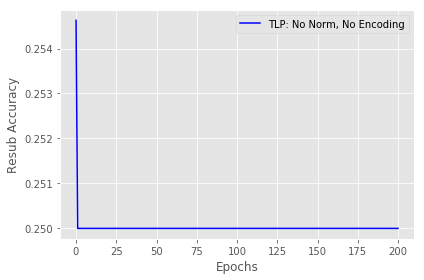

In [58]:
accuracy_vs_epochs(nn, X_train, y_train, X_test, y_test, title="TLP: No Norm, No Encoding", color="blue")

plt.show()

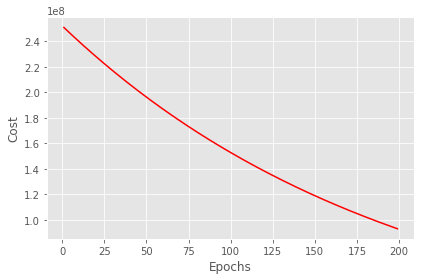

In [59]:
cost_vs_epochs(nn)

plt.show()

### 2.2 Two Layer Perceptron Model: Normalization, No Encoding 
- Normalization of continuous numeric feature data

In [60]:
continuous_numeric_columns = [col for col in X_train.columns if col != 'State']

In [61]:
# normalize continuous numeric feature data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()
X_train_norm[continuous_numeric_columns] = scaler.fit_transform(X_train[continuous_numeric_columns])
X_test_norm[continuous_numeric_columns] = scaler.fit_transform(X_test[continuous_numeric_columns])

In [62]:
%%time
nn_norm = TLP(**params)
nn_norm.fit(X_train_norm.to_numpy(), y_train, print_progress=10)
yhat_norm = nn_norm.predict(X_test_norm.to_numpy())
print('Test acc:', accuracy_score(y_test, yhat_norm))

Epoch: 200/200

Test acc: 0.24113036303630364
CPU times: user 1min 23s, sys: 28.2 s, total: 1min 51s
Wall time: 1min 52s


TLP: Norm, No Encoding :
Resubstitution acc: 0.2590797438371787
Validation acc: 0.24113036303630364


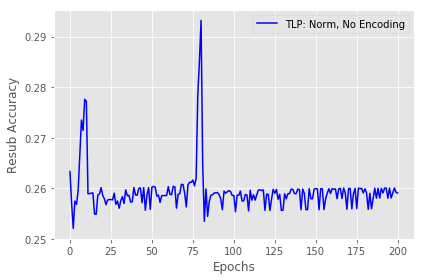

In [63]:
accuracy_vs_epochs(nn_norm, X_train_norm, y_train, X_test_norm, y_test, title="TLP: Norm, No Encoding", color="blue")

plt.show()

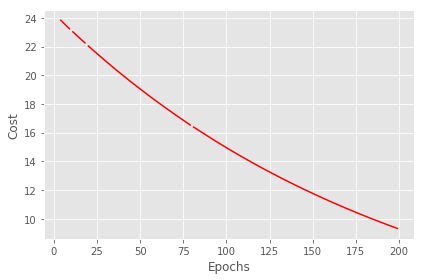

In [64]:
cost_vs_epochs(nn_norm)

plt.show()

### 2.3 Two Layer Perceptron Model: Normalization, Encoding 
- Normalize of continuous numeric data
- One hot encoding of categorical data

In [65]:
# one hot encode the categorical data (the state variable)
ohe_state = pd.get_dummies(df.State, prefix='State')

In [66]:
X_train_norm_encode = pd.concat([X_train_norm, ohe_state.loc[X_train_norm.index]], axis=1, sort=False)
X_train_norm_encode = X_train_norm_encode.drop(columns=['State'])

X_test_norm_encode = pd.concat([X_test_norm, ohe_state.loc[X_test_norm.index]], axis=1, sort=False)
X_test_norm_encode = X_test_norm_encode.drop(columns=['State'])

In [67]:
%%time
nn_norm_encode = TLP(**params)
nn_norm_encode.fit(X_train_norm_encode.to_numpy(), y_train, print_progress=10)
yhat_norm_encode = nn_norm_encode.predict(X_test_norm_encode.to_numpy())
print('Test acc:', accuracy_score(y_test, yhat_norm_encode))

Epoch: 200/200

Test acc: 0.6061606160616062
CPU times: user 2min 10s, sys: 42.7 s, total: 2min 53s
Wall time: 2min 54s


TLP: Norm, Encode :
Resubstitution acc: 0.7242411615053952
Validation acc: 0.6061606160616062


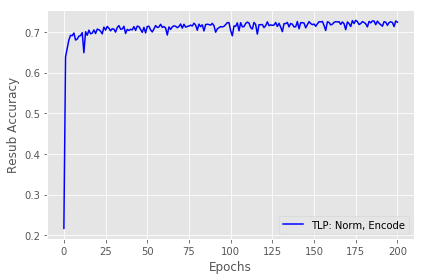

In [68]:
accuracy_vs_epochs(nn_norm_encode, X_train_norm_encode, y_train, X_test_norm_encode, y_test, 
               title="TLP: Norm, Encode", color="blue")

plt.show()

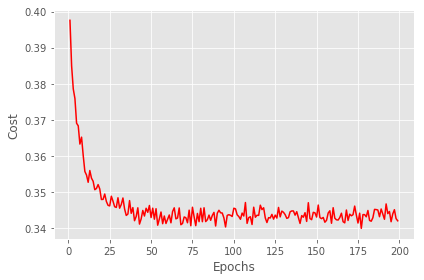

In [69]:
cost_vs_epochs(nn_norm_encode)

plt.show()

For the first two models (without normalization / without encoding and with normalization / without encoding), you can see that the cost converges, but the cost remains very large. This may indicate that without both normalization and encoding of categorical variables, the algorithm is unable to properly minimize the cost function and achieve a good accuracy.

Our last model (with both normalization and encoding) is much more what we would expect from our two layer MLP - an training accuracy that converges around 71%, a test accuracy of about 60%, and a cost that converges to a small number.

### Compare models using McNemar's test

McNemar's test is a statistical significance test that can be used to compare the performance of different machine learning models. The test is "recommended in those cases where the algorithms being compared can only be evaluated once" [[ref](https://machinelearningmastery.com/mcnemars-test-for-machine-learning/)]. We use this test to determine whether one model's performance is significantly different from another model's performance by calculating a contingency table and comparing the calculated `pvalue` to a specified `alpha`.

In [70]:
def calculate_contingency_table(cl1_array, cl2_array):
    table = np.zeros((2, 2))
    for r1, r2 in zip(cl1_array, cl2_array):
        if r1 and r2:
            table[0][0] += 1
        elif r1 and not r2:
            table[0][1] += 1
        elif not r1 and r2:
            table[1][0] += 1
        else:
            table[1][1] += 1
            
    return table

In [71]:
cl1_correct = y_test == yhat
cl2_correct = y_test == yhat_norm
cl3_correct = y_test == yhat_norm_encode

cl1_cl2_ct = calculate_contingency_table(cl1_correct, cl2_correct)
cl1_cl3_ct = calculate_contingency_table(cl1_correct, cl3_correct)
cl2_cl3_ct = calculate_contingency_table(cl2_correct, cl3_correct)

In [72]:
from statsmodels.stats.contingency_tables import mcnemar
alpha = 0.05

# code adapted from https://machinelearningmastery.com/mcnemars-test-for-machine-learning/
def mcnemar_test(table):
    # calculate mcnemar test from contingency table and print out statistical results
    result = mcnemar(table, exact=True)
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))

    # interpret the p-value
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')

In [73]:
print("Classifier 1 (C1): No Norm, No Encode")
print("Classifier 2 (C2): Norm, No Encode")
print("Classifier 3 (C3): Norm, Encode")
print()

print("C1 and C2:")
mcnemar_test(cl1_cl2_ct)
print()

print("C1 and C3:")
mcnemar_test(cl1_cl3_ct)
print()

print("C2 and C3:")
mcnemar_test(cl2_cl3_ct)
print()

Classifier 1 (C1): No Norm, No Encode
Classifier 2 (C2): Norm, No Encode
Classifier 3 (C3): Norm, Encode

C1 and C2:
statistic=28.000, p-value=0.000
Different proportions of errors (reject H0)

C1 and C3:
statistic=2268.000, p-value=0.000
Different proportions of errors (reject H0)

C2 and C3:
statistic=2263.000, p-value=0.000
Different proportions of errors (reject H0)



The McNemar test demonstrates that all of the models' performances are significantly different from one another. All three McNemar tests (between the 1st and 2nd classifier, between the 2nd and 3rd classifer, and between the 1st and 3rd classifer) result in the p-value being below alpha of 0.05, which means that we reject the null hypothesis and that there is a statistically significant difference in the disagreement between each pair of models. This shows us that normalization of continuous numeric data and one hot encoding of categorical data is a must when it comes to preprocessing before using neural networks.

## 3. Modeling

In [74]:
# base classifier model for three, four, and five layer MLP models

import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class CustomMLPBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))

### 3.1 Three Layer MLP

In [109]:
class ThreeLayerMLP(CustomMLPBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

        super().__init__(**kwds)
    
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        # suggested relu/sigmoid bounds from Xavier Glorot and Yoshua Bengio
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + W1.shape[0] + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, W1.shape[0] + 1))
        W2[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        init_bound = 4*np.sqrt(6 / (self.n_output_ + W2.shape[0] + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_output_, W2.shape[0] + 1)) 
        W3[:,:1] = 0
        
        return W1, W2, W3
    
    def _feedforward(self, X, W1, W2, W3):
        """Compute feedforward step
        """
        # A1->W1->ReLu->A2->W2->ReLu->A3->W3->Sigmoid->A4
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._relu(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._relu(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4
        
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3 = self._initialize_weights()
        
        # save average magnitudes of gradients
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        
        # momentum values
        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)
        delta_W3_prev = np.zeros(self.W3.shape)

        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            mini_grad1 = np.zeros(self.minibatches)
            mini_grad2 = np.zeros(self.minibatches)
            mini_grad3 = np.zeros(self.minibatches)
            
            for j, idx in enumerate(mini):

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3)
                
                cost = self._cost(A4,Y_enc[:, idx],self.W1,self.W2,self.W3)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, Z1=Z1, Z2=Z2, Z3=Z3,
                                                  Y_enc=Y_enc[:, idx],W1=self.W1,W2=self.W2, W3=self.W3)
                
                # saving average gradients within mini-batches
                mini_grad1[j] = np.average(abs(grad1))
                mini_grad2[j] = np.average(abs(grad2))
                mini_grad3[j] = np.average(abs(grad3))
                
                # momentum calculations
                delta_W1, delta_W2, delta_W3 = self.eta * grad1, self.eta * grad2, self.eta * grad3
                self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
                self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
                self.W3 -= (delta_W3 + (self.alpha * delta_W3_prev))
                delta_W1_prev, delta_W2_prev, delta_W3_prev = delta_W1, delta_W2, delta_W3
            
            # save average gradients
            self.grad_w1_[i] = np.average(abs(mini_grad1))
            self.grad_w2_[i] = np.average(abs(mini_grad2))
            self.grad_w3_[i] = np.average(abs(mini_grad3))

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
        return self
    
    def _cost(self,A4,Y_enc,W1,W2,W3):
        '''Get the objective function value'''
        
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A4)+(1-Y_enc)*np.log(1-A4))))
        L2_term = self._L2_reg(self.l2_C, W1, W2) + self._L2_reg(self.l2_C, W2, W3)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """ Compute gradient step using backpropagation.
        """
        
        # vectorized backpropagation
        V3 = (A4-Y_enc)

        Z2_with_bias = self._add_bias_unit(Z2,how='row')
        V2 = (W3.T @ V3) 
        V2[Z2_with_bias<=0] = 0
        
        Z1_with_bias = self._add_bias_unit(Z1,how='row')
        V1 = (W2.T @ V2[1:,:])
        V1[Z1_with_bias<=0] = 0
        
        grad3 = V3 @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)
        grad3[:, 1:] += (W3[:, 1:] * self.l2_C)

        return grad1, grad2, grad3
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2, self.W3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred

In [110]:
params

{'n_hidden': 40,
 'C': 0.1,
 'epochs': 200,
 'eta': 0.001,
 'alpha': 0.001,
 'minibatches': 50,
 'shuffle': True,
 'random_state': 1}

In [111]:
%%time
nn_three_layer = ThreeLayerMLP(**params)
nn_three_layer.fit(X_train_norm_encode.to_numpy(), y_train, print_progress=10)
yhat_three_layer = nn_three_layer.predict(X_test_norm_encode.to_numpy())
print('Test acc:', accuracy_score(y_test, yhat_three_layer))

Epoch: 200/200

Test acc: 0.5583058305830583
CPU times: user 2min 56s, sys: 51.9 s, total: 3min 48s
Wall time: 3min 48s


Three Layer MLP :
Resubstitution acc: 0.5400254408281429
Validation acc: 0.5583058305830583


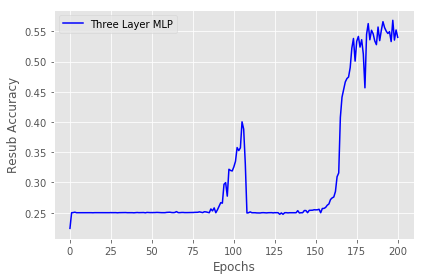

In [112]:
accuracy_vs_epochs(nn_three_layer, X_train_norm_encode, y_train, X_test_norm_encode, y_test, 
                   title="Three Layer MLP", color="blue")

plt.show()

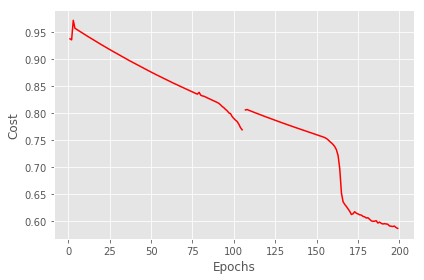

In [113]:
cost_vs_epochs(nn_three_layer)

plt.show()

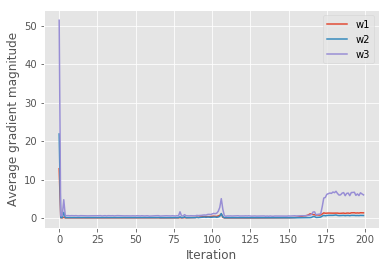

In [81]:
# plot average gradient magnitudes

ax = plt.subplot(1,1,1)
plt.plot(abs(nn_three_layer.grad_w1_), label='w1')
plt.plot(abs(nn_three_layer.grad_w2_), label='w2')
plt.plot(abs(nn_three_layer.grad_w3_), label='w3')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

We achieve about a 56% accuracy with a three layer model, with all hyperparameters remaining the same as for the two layer models. This is slightly lower than our optimal two layer model.

Our plots of the accuracy and cost vs. epochs shows that the value of our loss function (and therefore our training accuracy) is not converging quickly. We can explore hyperparameter tuning to improve the performance of our multi-layer perceptron neural network, which may result in better backpropagation and faster convergence.

### 3.2 Four Layer MLP

In [102]:
class FourLayerMLP(CustomMLPBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
        super().__init__(**kwds)
    
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + W1.shape[0] + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, W1.shape[0] + 1))
        W2[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + W2.shape[0] + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, W2.shape[0] + 1))
        W3[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + W3.shape[0] + 1))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_output_, W3.shape[0] + 1)) 
        W4[:,:1] = 0
        
        return W1, W2, W3, W4
    
    def _feedforward(self, X, W1, W2, W3, W4):
        """Compute feedforward step
        """
        # A1->W1->ReLu->A2->W2->ReLu->A3->W3->ReLu->A4->W4->Sigmoid->A5
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._relu(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._relu(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._relu(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._sigmoid(Z4) # never use relu as last layer for classification (yuck!)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5
        
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4 = self._initialize_weights()
        
        # save average magnitudes of gradients
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        
        # momentum values
        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)
        delta_W3_prev = np.zeros(self.W3.shape)
        delta_W4_prev = np.zeros(self.W4.shape)

        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            mini_grad1 = np.zeros(self.minibatches)
            mini_grad2 = np.zeros(self.minibatches)
            mini_grad3 = np.zeros(self.minibatches)
            mini_grad4 = np.zeros(self.minibatches)
            
            for j, idx in enumerate(mini):

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.W4)
                
                cost = self._cost(A5,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5,
                                                                Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4,
                                                                Y_enc=Y_enc[:, idx],
                                                                W1=self.W1,W2=self.W2, W3=self.W3, W4=self.W4)
                
                # saving average gradients within mini-batches
                mini_grad1[j] = np.average(abs(grad1))
                mini_grad2[j] = np.average(abs(grad2))
                mini_grad3[j] = np.average(abs(grad3))
                mini_grad4[j] = np.average(abs(grad4))

                # momentum calculations
                delta_W1, delta_W2, delta_W3, delta_W4 = self.eta * grad1, self.eta * grad2, self.eta * grad3, self.eta * grad4
                self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
                self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
                self.W3 -= (delta_W3 + (self.alpha * delta_W3_prev))
                self.W4 -= (delta_W4 + (self.alpha * delta_W4_prev))
                delta_W1_prev, delta_W2_prev, delta_W3_prev, delta_W4_prev = delta_W1, delta_W2, delta_W3, delta_W4
            
            # save average gradients
            self.grad_w1_[i] = np.average(abs(mini_grad1))
            self.grad_w2_[i] = np.average(abs(mini_grad2))
            self.grad_w3_[i] = np.average(abs(mini_grad3))
            self.grad_w4_[i] = np.average(abs(mini_grad4))
            
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
        return self
    
    def _cost(self,A5,Y_enc,W1,W2,W3,W4):
        '''Get the objective function value'''
        
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A5)+(1-Y_enc)*np.log(1-A5))))
        L2_term = self._L2_reg(self.l2_C, W1, W2) + self._L2_reg(self.l2_C, W2, W3) + self._L2_reg(self.l2_C, W3, W4)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4):
        """ Compute gradient step using backpropagation.
        """
        
        # vectorized backpropagation
        V4 = (A5-Y_enc)
        
        Z3_with_bias = self._add_bias_unit(Z3,how='row')
        V3 = (W4.T @ V4) 
        V3[Z3_with_bias<=0] = 0

        Z2_with_bias = self._add_bias_unit(Z2,how='row')
        V2 = (W3.T @ V3[1:,:]) 
        V2[Z2_with_bias<=0] = 0
        
        Z1_with_bias = self._add_bias_unit(Z1,how='row')
        V1 = (W2.T @ V2[1:,:])
        V1[Z1_with_bias<=0] = 0
        
        grad4 = V4 @ A4.T
        grad3 = V3[1:,:] @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)
        grad3[:, 1:] += (W3[:, 1:] * self.l2_C)
        grad4[:, 1:] += (W4[:, 1:] * self.l2_C)

        return grad1, grad2, grad3, grad4
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, A5 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4)
        y_pred = np.argmax(A5, axis=0)
        return y_pred

In [103]:
new_params = dict(n_hidden=40, 
              C=3, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              alpha=0.001,
              minibatches=50,
              shuffle=True,
              random_state=1)

In [104]:
%%time
nn_four_layer = FourLayerMLP(**new_params)
nn_four_layer.fit(X_train_norm_encode.to_numpy(), y_train, print_progress=10)
yhat_four_layer = nn_four_layer.predict(X_test_norm_encode.to_numpy())
print('Test acc:', accuracy_score(y_test, yhat_four_layer))

Epoch: 200/200

Test acc: 0.14782728272827284
CPU times: user 2min 4s, sys: 34.4 s, total: 2min 39s
Wall time: 2min 39s


Four Layer MLP :
Resubstitution acc: 0.25
Validation acc: 0.14782728272827284


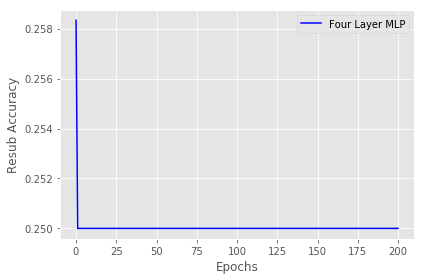

In [105]:
accuracy_vs_epochs(nn_four_layer, X_train_norm_encode, y_train, X_test_norm_encode, y_test, 
                   title="Four Layer MLP", color="blue")

plt.show()

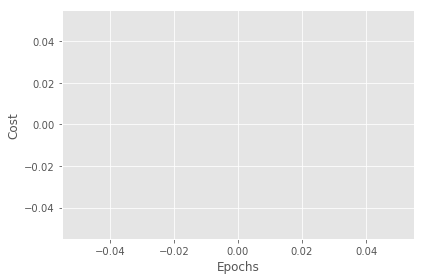

In [106]:
cost_vs_epochs(nn_four_layer)

plt.show()

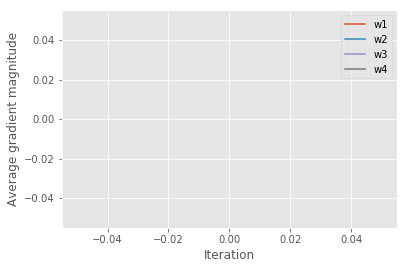

In [107]:
# plot average gradient magnitudes

ax = plt.subplot(1,1,1)
plt.plot(abs(nn_four_layer.grad_w1_), label='w1')
plt.plot(abs(nn_four_layer.grad_w2_), label='w2')
plt.plot(abs(nn_four_layer.grad_w3_), label='w3')
plt.plot(abs(nn_four_layer.grad_w4_), label='w4')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

We achieve about a 15% accuracy with a five layer model, with all hyperparameters except C remaining the same as for the two layer and three layer models. This is a much worse performance in terms of accuracy than any of our previous models.

Though our cost and average gradient magnitudes are converging, we noticed that our original hyperparameters led to an exploding gradient problem, so we increased value of C (our L2 regularization constant) to combat this. Unfortunately, our accuracy is still very poor, which could mean one (or more) of a few things:
- Our implementation of our multilayer perceptron is flawed.
- Three layers is the optimal # of layers for this problem.
- We can tune our hyperparameters better to combat the issue of exploding gradients and allow our algorithm to minimize cost faster.
- We need a better adaptive learning technique to avoid getting stuck in local minima so that we can get to a better solution.

### 3.3 Five Layer MLP

In [88]:
class FiveLayerMLP(CustomMLPBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, minibatches=1, **kwds):        
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
        super().__init__(**kwds)
    
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + W1.shape[0] + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, W1.shape[0] + 1))
        W2[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + W2.shape[0] + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, W2.shape[0] + 1))
        W3[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + W3.shape[0] + 1))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, W3.shape[0] + 1))
        W4[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + W4.shape[0] + 1))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, W4.shape[0] + 1)) 
        W5[:,:1] = 0
        
        return W1, W2, W3, W4, W5
    
    def _feedforward(self, X, W1, W2, W3, W4, W5):
        """Compute feedforward step
        """
        # A1->W1->ReLu->A2->W2->ReLu->A3->W3->ReLu->A4->W4->ReLu->A5->W5->Sigmoid->A5
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._relu(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._relu(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._relu(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._relu(Z4)
        A5 = self._add_bias_unit(A5, how='row')
        Z5 = W5 @ A5
        A6 = self._sigmoid(Z5) # never use relu as last layer for classification (yuck!)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
        
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()
        
        # save average magnitudes of gradients
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.grad_w5_ = np.zeros(self.epochs)
        
        # momentum values
        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)
        delta_W3_prev = np.zeros(self.W3.shape)
        delta_W4_prev = np.zeros(self.W4.shape)
        delta_W5_prev = np.zeros(self.W5.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            mini_grad1 = np.zeros(self.minibatches)
            mini_grad2 = np.zeros(self.minibatches)
            mini_grad3 = np.zeros(self.minibatches)
            mini_grad4 = np.zeros(self.minibatches)
            mini_grad5 = np.zeros(self.minibatches)
            
            for j, idx in enumerate(mini):

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                               self.W1,
                                                               self.W2,
                                                               self.W3,
                                                               self.W4,
                                                               self.W5)
                
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6,
                                                                Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                                Y_enc=Y_enc[:, idx],
                                                                W1=self.W1,W2=self.W2, W3=self.W3, W4=self.W4, W5=self.W5)

                # saving average gradients within mini-batches
                mini_grad1[j] = np.average(abs(grad1))
                mini_grad2[j] = np.average(abs(grad2))
                mini_grad3[j] = np.average(abs(grad3))
                mini_grad4[j] = np.average(abs(grad4))
                mini_grad5[j] = np.average(abs(grad5))
                
                # momentum calculations
                delta_W1, delta_W2, delta_W3, delta_W4, delta_W5 = self.eta * grad1, self.eta * grad2, self.eta * grad3, self.eta * grad4, self.eta * grad5
                    
                self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
                self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
                self.W3 -= (delta_W3 + (self.alpha * delta_W3_prev))
                self.W4 -= (delta_W4 + (self.alpha * delta_W4_prev))
                self.W5 -= (delta_W5 + (self.alpha * delta_W5_prev))
                
                delta_W1_prev, delta_W2_prev, delta_W3_prev, delta_W4_prev, delta_W5_prev = delta_W1, delta_W2, delta_W3, delta_W4, delta_W5
            
            # save average gradients
            self.grad_w1_[i] = np.average(abs(mini_grad1))
            self.grad_w2_[i] = np.average(abs(mini_grad2))
            self.grad_w3_[i] = np.average(abs(mini_grad3))
            self.grad_w4_[i] = np.average(abs(mini_grad4))
            self.grad_w5_[i] = np.average(abs(mini_grad5))
            
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
        return self
    
    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        '''Get the objective function value'''
        
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A6)+(1-Y_enc)*np.log(1-A6))))
        L2_term = self._L2_reg(self.l2_C, W1, W2) + self._L2_reg(self.l2_C, W2, W3) \
                    + self._L2_reg(self.l2_C, W3, W4) + self._L2_reg(self.l2_C, W4, W5)
        
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        """ Compute gradient step using backpropagation.
        """
        
        # vectorized backpropagation
        V5 = (A6-Y_enc)
        
        Z4_with_bias = self._add_bias_unit(Z4,how='row')
        V4 = (W5.T @ V5) 
        V4[Z4_with_bias<=0] = 0
        
        Z3_with_bias = self._add_bias_unit(Z3,how='row')
        V3 = (W4.T @ V4[1:,:]) 
        V3[Z3_with_bias<=0] = 0

        Z2_with_bias = self._add_bias_unit(Z2,how='row')
        V2 = (W3.T @ V3[1:,:]) 
        V2[Z2_with_bias<=0] = 0
        
        Z1_with_bias = self._add_bias_unit(Z1,how='row')
        V1 = (W2.T @ V2[1:,:])
        V1[Z1_with_bias<=0] = 0
        
        grad5 = V5 @ A5.T
        grad4 = V4[1:,:] @ A4.T
        grad3 = V3[1:,:] @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)
        grad3[:, 1:] += (W3[:, 1:] * self.l2_C)
        grad4[:, 1:] += (W4[:, 1:] * self.l2_C)
        grad5[:, 1:] += (W5[:, 1:] * self.l2_C)

        return grad1, grad2, grad3, grad4, grad5
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred

In [89]:
new_params = dict(n_hidden=40, 
              C=3, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              alpha=0.001,
              minibatches=50,
              shuffle=True,
              random_state=1)

In [90]:
%%time
nn_five_layer = FiveLayerMLP(**new_params)
nn_five_layer.fit(X_train_norm_encode.to_numpy(), y_train, print_progress=10)
yhat_five_layer = nn_five_layer.predict(X_test_norm_encode.to_numpy())
print('Test acc:', accuracy_score(y_test, yhat_five_layer))

Epoch: 200/200

Test acc: 0.14782728272827284
CPU times: user 4min 6s, sys: 1min 18s, total: 5min 24s
Wall time: 5min 25s


Four Layer MLP :
Resubstitution acc: 0.25
Validation acc: 0.14782728272827284


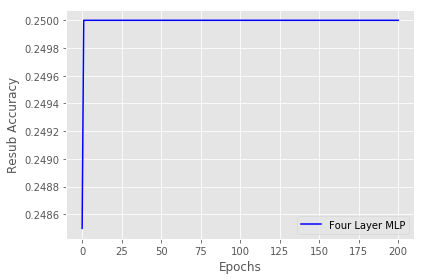

In [91]:
accuracy_vs_epochs(nn_five_layer, X_train_norm_encode, y_train, X_test_norm_encode, y_test, 
                   title="Four Layer MLP", color="blue")

plt.show()

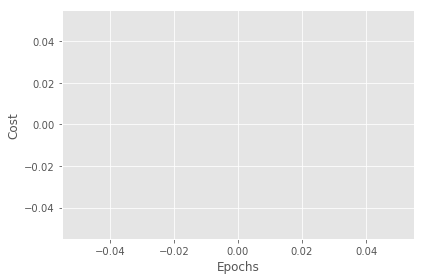

In [92]:
cost_vs_epochs(nn_five_layer)

plt.show()

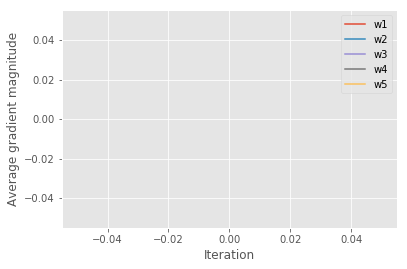

In [93]:
# plot average gradient magnitudes

ax = plt.subplot(1,1,1)
plt.plot(abs(nn_five_layer.grad_w1_), label='w1')
plt.plot(abs(nn_five_layer.grad_w2_), label='w2')
plt.plot(abs(nn_five_layer.grad_w3_), label='w3')
plt.plot(abs(nn_five_layer.grad_w4_), label='w4')
plt.plot(abs(nn_five_layer.grad_w5_), label='w5')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

We achieve about a 14% accuracy with a five layer model, with all hyperparameters except C remaining the same as for the two layer models. This is a much worse performance in terms of accuracy than our optimal two or three layer models, and about the same as our four layer model.

Again, as mentioned above, this is an issue relating to exploding gradients, which you can see from the cost and average gradient magnitudes plots (the values were not able to be plotted). Our training accuracy is basically as good as random chance (0.25), and our validation accuracy is even worse, which is definitely not ideal. We can probably conclude that a six layer model would continue to do poorly and/or worse than our five layer model. 

We would appreciate any feedback on our models, as this was an issue we ran into at almost every step. 

### 3.4 AdaGrad Adaptive Strategy

In [94]:
class FiveLayerMLPAdaGrad(FiveLayerMLP):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, minibatches=1, **kwds):        
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.eps = 10e-8
        
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()
        
        # save average magnitudes of gradients
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.grad_w5_ = np.zeros(self.epochs)
        
        # AdaGrad initial values
        G1_prev = np.zeros((self.W1.shape[0], self.W1.shape[0]))
        G2_prev = np.zeros((self.W2.shape[0], self.W2.shape[0]))
        G3_prev = np.zeros((self.W3.shape[0], self.W3.shape[0]))
        G4_prev = np.zeros((self.W4.shape[0], self.W4.shape[0]))
        G5_prev = np.zeros((self.W5.shape[0], self.W5.shape[0]))

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            mini_grad1 = np.zeros(self.minibatches)
            mini_grad2 = np.zeros(self.minibatches)
            mini_grad3 = np.zeros(self.minibatches)
            mini_grad4 = np.zeros(self.minibatches)
            mini_grad5 = np.zeros(self.minibatches)
            
            for j, idx in enumerate(mini):

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                               self.W1,
                                                               self.W2,
                                                               self.W3,
                                                               self.W4,
                                                               self.W5)
                
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6,
                                                                Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                                Y_enc=Y_enc[:, idx],
                                                                W1=self.W1,W2=self.W2, W3=self.W3, W4=self.W4, W5=self.W5)

                # saving average gradients within mini-batches
                mini_grad1[j] = np.average(abs(grad1))
                mini_grad2[j] = np.average(abs(grad2))
                mini_grad3[j] = np.average(abs(grad3))
                mini_grad4[j] = np.average(abs(grad4))
                mini_grad5[j] = np.average(abs(grad5))
                
                # AdaGrad calculations
                G1 = G1_prev + grad1 @ grad1.T
                G2 = G2_prev + grad2 @ grad2.T
                G3 = G3_prev + grad3 @ grad3.T
                G4 = G4_prev + grad4 @ grad4.T
                G5 = G5_prev + grad5 @ grad5.T

                rho_1 = np.full(grad1.shape, self.eta) / (np.sqrt(np.sum(np.diagonal(G1)) + 0.0001)) * grad1
                rho_2 = np.full(grad2.shape, self.eta) / (np.sqrt(np.sum(np.diagonal(G2)) + 0.0001)) * grad2
                rho_3 = np.full(grad3.shape, self.eta) / (np.sqrt(np.sum(np.diagonal(G3)) + 0.0001)) * grad3
                rho_4 = np.full(grad4.shape, self.eta) / (np.sqrt(np.sum(np.diagonal(G4)) + 0.0001)) * grad4
                rho_5 = np.full(grad5.shape, self.eta) / (np.sqrt(np.sum(np.diagonal(G5)) + 0.0001)) * grad5
                                    
                self.W1 -= rho_1
                self.W2 -= rho_2
                self.W3 -= rho_3
                self.W4 -= rho_4
                self.W5 -= rho_5
                
                G1_prev, G2_prev, G3_prev, G4_prev, G5_prev = G1, G2, G3, G4, G5
                            
            # save average gradients
            self.grad_w1_[i] = np.average(abs(mini_grad1))
            self.grad_w2_[i] = np.average(abs(mini_grad2))
            self.grad_w3_[i] = np.average(abs(mini_grad3))
            self.grad_w4_[i] = np.average(abs(mini_grad4))
            self.grad_w5_[i] = np.average(abs(mini_grad5))
            
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
        return self

In [95]:
new_params

{'n_hidden': 40,
 'C': 3,
 'epochs': 200,
 'eta': 0.001,
 'alpha': 0.001,
 'minibatches': 50,
 'shuffle': True,
 'random_state': 1}

In [96]:
%%time
nn_five_layer_adagrad = FiveLayerMLPAdaGrad(**new_params)
nn_five_layer_adagrad.fit(X_train_norm_encode.to_numpy(), y_train, print_progress=10)
yhat_five_layer_adagrad = nn_five_layer_adagrad.predict(X_test_norm_encode.to_numpy())
print('Test acc:', accuracy_score(y_test, yhat_five_layer_adagrad))

Epoch: 200/200

Test acc: 0.36152365236523654
CPU times: user 4min 31s, sys: 18.1 s, total: 4min 49s
Wall time: 4min 50s


#### Compare FiveLayerMLP with momentum with FiveLayerMLP with AdaGrad

In [101]:
cl1_correct = y_test == yhat_five_layer
cl2_correct = y_test == yhat_five_layer_adagrad
cl1_cl2_ct = calculate_contingency_table(cl1_correct, cl2_correct)

print("Classifier 1 (C1): With Momentum")
print("Classifier 2 (C2): With AdaGrad")
print()

print("C1 and C2:")
mcnemar_test(cl1_cl2_ct)
print()

Classifier 1 (C1): With Momentum
Classifier 2 (C2): With AdaGrad

C1 and C2:
statistic=2016.000, p-value=0.000
Different proportions of errors (reject H0)



We achieve about a 36% accuracy with a five layer model implemented with the AdaGrad adaptive strategy.

Though we still have the existing issue with our base five layer model, the AdaGrad adaptive strategy instead of our original momentum strategy increased our accuracy significantly, which is a great sign. Since our original implementation used momentum as an adaptive strategy, we did a statistical comparison between our original five layer model and the new five layer model with AdaGrad using McNemar's test. Running the test resulting in us rejecting the null hypothesis, which means that the performance of the two five layer models is statistically different.

In the future, we could test our AdaGrad adaptive strategy with our three layer model, which was our best-performing model, to see if the AdaGrad strategy would increase our testing accuracy above 60%.

## 4. Exceptional Credit
### Implementing AdaM

In [98]:
class FiveLayerMLPAdaM(FiveLayerMLP):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, minibatches=1, beta1=0.9, beta2=0.999, **kwds): 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = 10e-8
        
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()
        
        # save average magnitudes of gradients
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.grad_w5_ = np.zeros(self.epochs)
        
        # AdaM initial values
        m1_prev = np.zeros(self.W1.shape)
        m2_prev = np.zeros(self.W2.shape)
        m3_prev = np.zeros(self.W3.shape)
        m4_prev = np.zeros(self.W4.shape)
        m5_prev = np.zeros(self.W5.shape)
        
        v1_prev = np.zeros(self.W1.shape)
        v2_prev = np.zeros(self.W2.shape)
        v3_prev = np.zeros(self.W3.shape)
        v4_prev = np.zeros(self.W4.shape)
        v5_prev = np.zeros(self.W5.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            mini_grad1 = np.zeros(self.minibatches)
            mini_grad2 = np.zeros(self.minibatches)
            mini_grad3 = np.zeros(self.minibatches)
            mini_grad4 = np.zeros(self.minibatches)
            mini_grad5 = np.zeros(self.minibatches)
            
            for j, idx in enumerate(mini):

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                               self.W1,
                                                               self.W2,
                                                               self.W3,
                                                               self.W4,
                                                               self.W5)
                
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6,
                                                                Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                                Y_enc=Y_enc[:, idx],
                                                                W1=self.W1,W2=self.W2, W3=self.W3, W4=self.W4, W5=self.W5)

                # saving average gradients within mini-batches
                mini_grad1[j] = np.average(abs(grad1))
                mini_grad2[j] = np.average(abs(grad2))
                mini_grad3[j] = np.average(abs(grad3))
                mini_grad4[j] = np.average(abs(grad4))
                mini_grad5[j] = np.average(abs(grad5))
                
                # AdaM calculations
                m1 = self.beta1 * m1_prev + (1 - self.beta1) * grad1
                m2 = self.beta1 * m2_prev + (1 - self.beta1) * grad2
                m3 = self.beta1 * m3_prev + (1 - self.beta1) * grad3
                m4 = self.beta1 * m4_prev + (1 - self.beta1) * grad4
                m5 = self.beta1 * m5_prev + (1 - self.beta1) * grad5
                
                v1 = self.beta2 * v1_prev + (1 - self.beta2) * np.sqrt(grad1)
                v2 = self.beta2 * v2_prev + (1 - self.beta2) * np.sqrt(grad2)
                v3 = self.beta2 * v3_prev + (1 - self.beta2) * np.sqrt(grad3)
                v4 = self.beta2 * v4_prev + (1 - self.beta2) * np.sqrt(grad4)
                v5 = self.beta2 * v5_prev + (1 - self.beta2) * np.sqrt(grad5)
                
                m1_boost = m1 / (1 - self.beta1 ** i)
                m2_boost = m2 / (1 - self.beta1 ** i)
                m3_boost = m3 / (1 - self.beta1 ** i)
                m4_boost = m4 / (1 - self.beta1 ** i)
                m5_boost = m5 / (1 - self.beta1 ** i)
                
                v1_boost = v1 / (1 - self.beta2 ** i)
                v2_boost = v2 / (1 - self.beta2 ** i)
                v3_boost = v3 / (1 - self.beta2 ** i)
                v4_boost = v4 / (1 - self.beta2 ** i)
                v5_boost = v5 / (1 - self.beta2 ** i)
                
                rho_1 = self.eta * m1_boost / (np.sqrt(v1_boost) + self.eps)
                rho_2 = self.eta * m2_boost / (np.sqrt(v2_boost) + self.eps)
                rho_3 = self.eta * m3_boost / (np.sqrt(v3_boost) + self.eps)
                rho_4 = self.eta * m4_boost / (np.sqrt(v4_boost) + self.eps)
                rho_5 = self.eta * m5_boost / (np.sqrt(v5_boost) + self.eps)
                                    
                self.W1 -= rho_1
                self.W2 -= rho_2
                self.W3 -= rho_3
                self.W4 -= rho_4
                self.W5 -= rho_5
                
                m1_prev, m2_prev, m3_prev, m4_prev, m5_prev = m1, m2, m3, m4, m5
                v1_prev, v2_prev, v3_prev, v4_prev, v5_prev = v1, v2, v3, v4, v5
                            
            # save average gradients
            self.grad_w1_[i] = np.average(abs(mini_grad1))
            self.grad_w2_[i] = np.average(abs(mini_grad2))
            self.grad_w3_[i] = np.average(abs(mini_grad3))
            self.grad_w4_[i] = np.average(abs(mini_grad4))
            self.grad_w5_[i] = np.average(abs(mini_grad5))
            
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
        return self

In [99]:
new_params = dict(n_hidden=40, 
              C=3, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              alpha=0.001,
              minibatches=50,
              shuffle=True,
              random_state=1,
              beta1=0.9,
              beta2=0.999)

In [100]:
%%time
nn_five_layer_adam = FiveLayerMLPAdaM(**new_params)
nn_five_layer_adam.fit(X_train_norm_encode.to_numpy(), y_train, print_progress=10)
yhat_five_layer_adam = nn_five_layer_adam.predict(X_test_norm_encode.to_numpy())
print('Test acc:', accuracy_score(y_test, yhat_five_layer_adam))

Epoch: 200/200

Test acc: 0.14782728272827284
CPU times: user 3min 56s, sys: 11.4 s, total: 4min 8s
Wall time: 4min 9s


We achieve about a 15% accuracy with a five layer model implemented with the AdaM adaptive strategy, which incorporates adaptive gradients with a cooling schedule and momentum. 

Our AdaM model does not perform well compared to our AdaGrad model, which is unexpected, as AdaM is considered a heuristically good adaptive learning strategy to use. However, this may be due to our existing (base) model issues, and not the adaptive learning strategy itself.

In the future, we could test our AdaM adaptive strategy with our optimal two layer or three layer model, which performed the best in terms of accuracy, to see if the AdaM strategy would increase our testing accuracy.